# Helper functions for the de-dispersion code

### Jul 30, 2020

## Code

In [6]:
import sys
import csv
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
# import pyrex.custom.analysis
# import pyrex.custom.araroot as araroot



In [18]:
def read_ARA_antenna_model(finame):
    fi = open(finame, 'r')
    rdr = csv.reader(fi, delimiter=' ', skipinitialspace=True)
    freq = 0.
    SWR = 999.
    impedance = 0.
    table = []
    for row in rdr:
    #    print(row)
        if( row[0] == 'freq'):
            freq = float(row[2])
        elif( row[0] == 'SWR'):
            SWR = float(row[2])
#         elif( row[0] == 'Impedance'):
#             impedance = float(row[2])
        elif( row[0] == 'Theta' ):
            continue
        else:
            theta = float(row[0])
            phi = float(row[2])
            gaindb= float(row[4])
            gain = float(row[6])
            phase = float(row[8])
            row = {'freq':freq, 'SWR':SWR, 'theta':theta, 'phi':phi, 'gaindb':gaindb, 'gain':gain, 'phase':phase}
#             print(row)
            table.append(row)
    return pd.DataFrame(table)

In [33]:
bicone = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_bicone6in_output.txt")
dipole = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_dipoletest1_output.txt")

In [34]:
borehole_bicone = bicone.loc[(bicone['phi']==90) & (bicone['theta']==90)]
borehole_dipole = dipole.loc[(dipole['phi']==90) & (dipole['theta']==90)]

In [35]:
borehole_bicone.tail()

,freq,SWR,theta,phi,gaindb,gain,phase
147204,1000.0,1.45,90.0,90.0,-0.16,0.96,22.10
149868,1016.7,1.45,90.0,90.0,-0.80,0.83,3.58
152532,1033.4,1.47,90.0,90.0,-2.10,0.62,-5.10
155196,1050.0,1.48,90.0,90.0,-1.46,0.71,-7.13
157860,1066.7,1.46,90.0,90.0,-0.59,0.87,-21.57


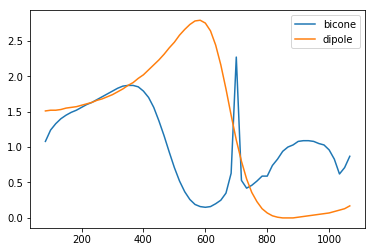

In [38]:
plt.plot(borehole_bicone["freq"], borehole_bicone["gain"], label = "bicone")
plt.plot(borehole_dipole["freq"], borehole_dipole["gain"], label = "dipole")
plt.legend()

### Antenna gain as a function of theta at 400 MHz

In [24]:
bicone.freq.unique()

array([  83.33,  100.  ,  116.67,  133.33,  150.  ,  166.67,  183.34,
        200.  ,  216.67,  233.34,  250.  ,  266.67,  283.34,  300.  ,
        316.67,  333.34,  350.  ,  366.67,  383.34,  400.01,  416.67,
        433.34,  450.01,  466.67,  483.34,  500.01,  516.68,  533.34,
        550.01,  566.68,  583.34,  600.01,  616.68,  633.34,  650.01,
        666.68,  683.35,  700.01,  716.68,  733.35,  750.01,  766.68,
        783.35,  800.01,  816.68,  833.35,  850.02,  866.68,  883.35,
        900.02,  916.68,  933.35,  950.02,  966.68,  983.35, 1000.  ,
       1016.7 , 1033.4 , 1050.  , 1066.7 ])

In [39]:
at400MHz = bicone.loc[(bicone['phi']==90) & (bicone['freq']==400.01)]
at400MHz_dipole = dipole.loc[(dipole['phi']==90) & (dipole['freq']==400.01)]


In [26]:
at400MHz.tail()

,freq,SWR,theta,phi,gaindb,gain,phase
51314,400.01,1.87,160.0,90.0,-7.27,0.19,-46.43
51315,400.01,1.87,165.0,90.0,-9.47,0.11,-43.95
51316,400.01,1.87,170.0,90.0,-12.78,0.05,-42.23
51317,400.01,1.87,175.0,90.0,-18.67,0.01,-41.23
51318,400.01,1.87,180.0,90.0,-57.17,0.00,177.37


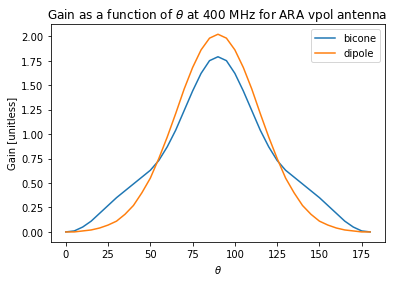

In [41]:
plt.plot(at400MHz.theta, at400MHz.gain, label = "bicone")
plt.plot(at400MHz_dipole.theta, at400MHz_dipole.gain, label = "dipole")

plt.ylabel("Gain [unitless]")
plt.xlabel("$\\theta$")
plt.title("Gain as a function of $\\theta$ at 400 MHz for ARA vpol antenna ")
plt.legend()

### Debug for function

In [46]:
at400MHz = bicone.loc[(bicone['phi']>=80) & (bicone['phi']<=100) & (bicone['freq']==400.01)]
at400MHz.phi.unique()

array([ 80.,  85.,  90.,  95., 100.])

### Function that will return the response for an input direction

In [ ]:
def getAntennaResponse(phi_in, theta_in, pol):
    """                                                                                                               
    Gets the antenna response for a given direction and polarization.                                                            
                                                                                                                      
    Parameters                                                                                                        
    ----------                                                                                                        
    phi_in : double                                                                                                    
        Incoming phi angle of signal, in degrees.       
    theta_in : double                                                                                                    
        Incoming theta angle of signal, in degrees.       
    pol : str                                                                                              
        vpol or hpol, depending on what response wants to be returned.                                                                     
                                                                                                                      
    Returns                                                                                                           
    -------                                                                                                           
    array (double freq, double gain, double phase)                                                                                                               
        An array containing the gain and phase as a function of frequency                                                                           
                                                                                                                      
    """
    if(pol=="vpol"):
        antenna = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_bicone6in_output.txt")
    if(pol=="hpol"):
        antenna = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_dipoletest1_output.txt")
    
    antenna_atPhiThe 


## Plots

## Comments